In [1]:
import os
import pickle

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow import keras
# Remove the following line
tf.compat.v1.disable_eager_execution()

# Code continues...


In [2]:
from keras import backend as K

In [3]:
def _calculate_reconstruction_loss(y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss


def calculate_kl_loss(model):
    # wrap `_calculate_kl_loss` such that it takes the model as an argument,
    # returns a function which can take arbitrary number of arguments
    # (for compatibility with `metrics` and utility in the loss function)
    # and returns the kl loss
    def _calculate_kl_loss(*args):
        kl_loss = -0.5 * K.sum(1 + model.log_variance - K.square(model.mu) -
                               K.exp(model.log_variance), axis=1)
        return kl_loss
    return _calculate_kl_loss

In [4]:
class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape
        self.conv_filters = conv_filters 
        self.conv_kernels = conv_kernels 
        self.conv_strides = conv_strides 
        self.latent_space_dim = latent_space_dim 
        self.reconstruction_loss_weight = 1000000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

        
  

    def compile(self, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    calculate_kl_loss(self)])

    def train(self, x_train, batch_size, num_epochs, callbacks=None):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True, callbacks=[checkpoint_callback] + callbacks)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
        return combined_loss

    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
        return reconstruction_loss

    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                               K.exp(self.log_variance), axis=1)
        return kl_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

# create a ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath=r'D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\Epoch one\model_weights_best.h5',
    save_weights_only=True,
    monitor='loss',  # monitor validation loss to determine the best model
    save_best_only=True,  # save only the best model
    save_freq='epoch'  # save after each epoch
)

In [6]:
LEARNING_RATE = 0.00005
BATCH_SIZE = 1
EPOCHS = 6
SPECTROGRAMS_PATH = r"D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\Test"


def load_fsdd(spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)
            if np.count_nonzero(np.isnan(spectrogram)):
                print(f"Avoided")
                continue
            x_train.append(spectrogram)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # -> (3500, 256,512 , 1)
    return x_train

def train(x_train, learning_rate, batch_size, epochs, callbacks=None):
    autoencoder = VAE(
        input_shape=(256, 512, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(1, 2, 2, 2, 1),
        latent_space_dim = 128
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.load_weights(r'D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\Epoch one\model_weights_best.h5')
    autoencoder.train(x_train, batch_size, epochs, callbacks=[])
    return autoencoder


In [7]:
path = r"D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\x_train.npy"

In [8]:
if __name__ == "__main__":
    #x_train = load_fsdd(SPECTROGRAMS_PATH)
    x_train = np.load(path)
    autoencoder = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS,callbacks=[])
    #autoencoder.save(r"D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\Epoch one)

Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 512, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 256, 512, 512 5120        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 256, 512, 512 0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_bn_1 (BatchNormalizatio (None, 256, 512, 512 2048        encoder_relu_1[0][0]             
____________________

Train on 8756 samples
Epoch 1/6
8756/8756 [==============================] - 3383s 385ms/sample - loss: 9644.5796 - _calculate_reconstruction_loss: 0.0093 - _calculate_kl_loss: 387.2467
Epoch 2/6
8756/8756 [==============================] - 3364s 384ms/sample - loss: 9548.6348 - _calculate_reconstruction_loss: 0.0092 - _calculate_kl_loss: 379.7803
Epoch 3/6
8756/8756 [==============================] - 3363s 384ms/sample - loss: 9481.5491 - _calculate_reconstruction_loss: 0.0091 - _calculate_kl_loss: 375.8351
Epoch 4/6
8756/8756 [==============================] - 3363s 384ms/sample - loss: 9418.6216 - _calculate_reconstruction_loss: 0.0090 - _calculate_kl_loss: 372.0265
Epoch 5/6
8756/8756 [==============================] - 3364s 384ms/sample - loss: 9362.7058 - _calculate_reconstruction_loss: 0.0090 - _calculate_kl_loss: 368.3742
Epoch 6/6
3017/8756 [=========>....................] - ETA: 36:45 - loss: 9246.0646 - _calculate_reconstruction_loss: 0.0089 - _calculate_kl_loss: 367.4500

# Reconstructing Trial

In [12]:
test = r"D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\log_numpy\Chika Chiko_segment37.wav.npy"
x = np.load(test)
autoencoder = VAE(
    input_shape=(256, 512, 1),
    conv_filters=(512, 256, 128, 64, 32),
    conv_kernels=(3, 3, 3, 3, 3),
    conv_strides=(1, 2, 2, 2, 1),
    latent_space_dim = 128
)
autoencoder.summary()
autoencoder.compile(0.00005)
autoencoder.load_weights(r'D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\Epoch one\model_weights_best.h5')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 512, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 256, 512, 512 5120        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 256, 512, 512 0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_bn_1 (BatchNormalizatio (None, 256, 512, 512 2048        encoder_relu_1[0][0]             
____________________________________________________________________________________________

In [14]:
X = []
X.append(x)
X = np.array(X)
X = X[..., np.newaxis]
X.shape

(1, 256, 512, 1)

In [16]:
out, _ = autoencoder.reconstruct(X)
print(out.shape)

C:\Users\elsha\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 256, 512, 1)


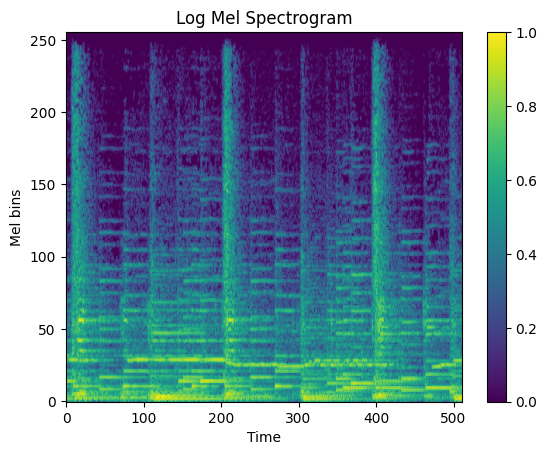

<Figure size 640x480 with 0 Axes>

In [19]:
from matplotlib import pyplot as plt

plt.imshow(x, origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Mel bins')
plt.title('Log Mel Spectrogram')
plt.show()
plt.clf()

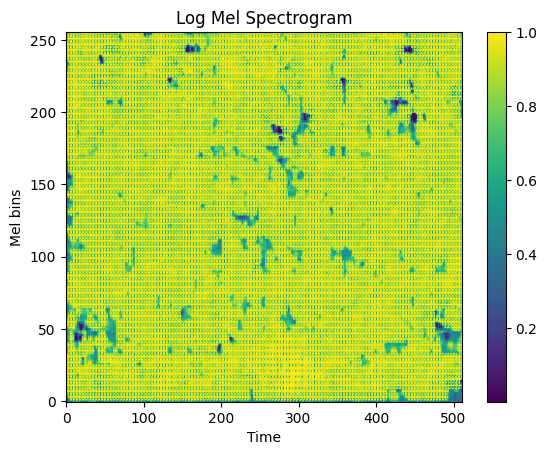

<Figure size 640x480 with 0 Axes>

In [20]:
plt.imshow(out[0, :, :, 0], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Mel bins')
plt.title('Log Mel Spectrogram')
plt.show()
plt.clf()

# Next

In [ ]:
#x_train = np.load(X_train_path)
model_path = "D:/Education/Semester 6/CSE 321 Project Based Learning on CSE/Generation one genre/Epoch one"
autoencoder1 = keras.models.load_model(r"D:\Education\Semester 6\CSE 321 Project Based Learning on CSE\Generation one genre\Epoch one\test.h5")
autoencoder1 = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS, callbacks=[])